[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/NktBkzn/HSE_DL_2021/blob/master/12_week/Weather_forecast_RNN.ipynb)

## Задача прогнозирования температуры

Во всех наших примерах в этом разделе мы будем играть с погодой
набором  временных рядов, записанных на метеостанции в Институте биогеохимии им. Макса Планка в Йене, Германия: http://www.bgc-jena.mpg.de/wetter/.

В этом наборе данных записано четырнадцать различных величин (таких как температура воздуха, атмосферное давление, влажность, направление ветра и т. Д.)
каждые десять минут, в течение нескольких лет. Исходные данные относятся к 2003 году, но мы ограничиваемся данными за 2009-2016 годы. Этот набор данных
идеально подходит для обучения работе с числовыми временными рядами. Мы будем использовать его для построения модели, которая принимает в качестве входных данных некоторые данные из недавнего прошлого (
несколько дней стоит данных) и прогнозирует температуру воздуха на 24 часа в будущем.


Посмотрим на данные!

In [1]:
import os


fname = 'hw_data/jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import pandas as pd

tmp = pd.read_csv(fname)
tmp.head(1)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3


переведем все в numpy array

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
float_data.shape

(420551, 14)

In [14]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

нарисуем график температуры

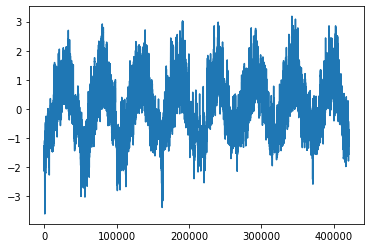

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # температура
plt.plot(range(len(temp)), temp)
plt.show()

На этом графике вы можете четко увидеть годовую периодичность температуры.

Вот более узкий график данных о температуре за первые десять дней (поскольку данные записываются каждые десять минут, мы получаем 144 точки данных
в день):

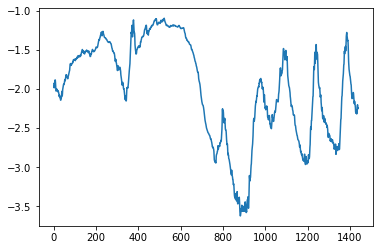

In [17]:
plt.plot(range(1440), temp[:1440])
plt.show()

На этом графике вы можете увидеть ежедневную периодичность, особенно заметную за последние 4 дня. Мы также можем отметить, что этот десятидневный период должен быть
взят из довольно холодного зимнего месяца.

Если бы мы пытались предсказать среднюю температуру для следующего месяца, учитывая данные за несколько месяцев, проблема была бы легкой из-за
достоверной годовой периодичности данных. Но, глядя на данные в масштабе дней, температура выглядит намного более хаотичной. 


In [18]:
TRAIN_VAL_TH = 200000
VAL_TEST_TH = 300000

In [19]:
mean = float_data[:TRAIN_VAL_TH].mean(axis=0)
float_data -= mean
std = float_data[:TRAIN_VAL_TH].std(axis=0)
float_data /= std

In [20]:
float_data.shape

(420551, 14)

In [21]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

Рассмотрим генератор данных, который мы будем использовать. Он возвращает кортеж `(samples, target)`, где `samples` - один батч данных, а
`target` -  массив целевых температур. Требуются следующие аргументы:

* `data`: исходный массив данных с плавающей запятой, который мы только что нормализовали в приведенном выше фрагменте кода.
* `lookback`: Сколько временных шагов назад должны пройти наши входные данные. Выбираем значение, равное 1440 (в нашем случае это кол-во прошедших минут).
* `delay`: через сколько шагов прогнозим
* `min_index` и` max_index`: индексы в массиве `data`, которые разграничивают временные шаги для отрисовки. 
* `shuffle`: перетасовать наши батчи или нарисовать их в хронологическом порядке.
* `batch_size`: количество данных на батч.
* `step`: период во временных шагах, с каким мы производим выборку данных. Мы установим его на 6, чтобы рисовать одну точку данных каждый час. Тогда длина полследовательности будет 1440:6= 240 (т.е. 240 10-ти минутных интервалов)

In [22]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),       # batch size
                           lookback // step, # seq_len
                           data.shape[-1]))  # features number
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):  # loop of batch size len
            indices = range(row - lookback, row, step) # indices form a sequence (total number of sequences = batch size)
            # print('indices', len(list(indices)), list(indices))
            # print(row + delay - step, '\n')
            samples[j] = data[indices]
            # [1] below means that temperature is being a target
            targets[j] = data[row + delay - step][1]
        yield samples, targets


Теперь давайте использовать нашу функцию абстрактного генератора для создания трех генераторов, одного для обучения, одного для проверки и одного для тестирования.


In [23]:
float_data.shape

(420551, 14)

In [24]:
lookback = 1440 
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=TRAIN_VAL_TH,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=TRAIN_VAL_TH+1,
                    max_index=VAL_TEST_TH,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=VAL_TEST_TH+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# number of steps needed to cover the whole datasets
train_steps = (TRAIN_VAL_TH - 0 - lookback) // batch_size
val_steps = (VAL_TEST_TH - (TRAIN_VAL_TH+1) - lookback) // batch_size
test_steps = (len(float_data) - (VAL_TEST_TH+1) - lookback) // batch_size

print(val_steps, test_steps)

769 930


In [35]:
next_batch = next(train_gen)
# type(next_batch)
next_batch

(array([[[-7.53069824e-01,  2.12399356e+00,  2.16834158e+00, ...,
           1.29498860e-01,  3.90655771e-01, -1.28048606e+00],
         [-6.88214651e-01,  1.97827200e+00,  2.01867512e+00, ...,
          -6.53167952e-04, -1.58541826e-01, -1.81608553e+00],
         [-5.76192081e-01,  1.85514293e+00,  1.88687928e+00, ...,
          -1.43820399e-01, -4.33140624e-01,  2.03990737e+00],
         ...,
         [ 2.78772883e-03,  5.71889475e-01,  5.66687087e-01, ...,
           7.15182986e-01,  1.09431519e+00,  1.09663346e+00],
         [ 3.69840924e-02,  4.28427161e-01,  4.21488285e-01, ...,
           4.09325720e-01,  8.96947305e-01,  1.09316979e+00],
         [ 3.93424623e-02,  4.69093644e-01,  4.61697184e-01, ...,
           3.24726902e-01,  2.87681221e-01,  1.08855156e+00]],
 
        [[-7.26801079e-02,  6.49833566e-01,  6.49338714e-01, ...,
           4.48371329e-01,  4.74072729e-02,  8.05684841e-01],
         [-8.44719574e-02,  7.24388785e-01,  7.24171943e-01, ...,
           6.17568965

In [36]:
# samples, targets = next(val_gen)

# samples.shape, targets.shape

Немного разберемся с процедурой формирования батча\
Создадим generator с небольшими значениями параметров, чтобы все можно было увидеть глазами

In [37]:
lookback = 1440
step = 6
delay = 144
batch_size = 8

tmp_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)

samples, targets = next(tmp_gen)

In [40]:
# samples
# targets

array([-2.08385776, -2.04770978, -2.01495067, -2.04770978, -2.05900603,
       -2.03754316, -2.02737654, -2.03641354])

Посмотрим на значения, которые вернул генератор, а именно на 0 и 6 элемент в батче (ВАЖНО: элементы в батче не перемешивались). 0 и 6 выбраны потому, что step=6, значит значения в `samples` под указанными индексами должны быть одинаковыми, только сдвинутыми на 1 относительно друг друга

`samples` имеет вид $bs \times SeqLen \times \#features$

In [41]:
idx1, idx2 = 0, 6
seqlen = 5
feature = 1

print(samples[idx1, :seqlen, feature])
print(samples[idx2, :seqlen, feature])

[-1.93135845 -1.88617347 -2.02511729 -2.02398767 -2.06804302]
[-1.88617347 -2.02511729 -2.02398767 -2.06804302 -2.1177465 ]


In [42]:
targets[:seqlen]

array([-2.08385776, -2.04770978, -2.01495067, -2.04770978, -2.05900603])

### Вывод:
В семинарском ноутбуке мы учили модель POS tagger, которая предсказывала для каждого слова (токена) в предложении его tag, т.е. часть речи. Поэтому в конструкции `nn.LSTM().forward()`, которая возвращает *`Outputs: output, (h_n, c_n)`*, нас интересовала только первая часть `output`. Она представляет собой последовательность выходов ячеек LSTM для каждого токена. 

Напротив, в рассматриваемой задаче нам нужно по временному ряду метеоролигических показателей (например, температура) получить 1 число: прогноз температуры через 24 часа. Соответственно теперь нас будет интересовать h_n среди выходов слоя `nn.LSTM`

Перед тем как реализовать реккурентную архитектуру сделаем бэйслайн прогноз

## Здравый смысл, бейзлайн



В нашем случае температурные временные ряды можно смело считать периодическими (завтра температура, вероятно, будет близка к
температура сегодня). Таким образом, подход здравого смысла будет всегда предсказывать, что температура через
24 часа будут равны температуре прямо сейчас. Давайте оценим этот подход, используя метрику средней абсолютной ошибки (MAE).


In [43]:
from tqdm import tqdm

def evaluate_naive_method():
    batch_maes = []
    for step in tqdm(range(val_steps)):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] # (все объекты выборки; время, соотвествующее моменту "сейчас"; столбец температура)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(f'MAE = {np.mean(batch_maes):.4f}')
    
evaluate_naive_method()

100%|███████████████████████████████████████████████████████████████████████████████| 769/769 [00:03<00:00, 211.96it/s]

MAE = 0.2780


Вроде более-менее понятно, попробуем побить baseline

## Реккурентная сетка
### Домашнее задание: 
Написать и обучить свою реккурентную сеть. Предлагается применить все возможные методы: bidirectional, num_layers ...

Жестких критериев, по которым будет оцениваться работа, нет
- Необходимо обучить модель и получить достойное качество
- Необходимо реализовать сеть через класс
- Нужно выделить на данных как train, так и val датасеты
- При появлении симптомов переобучения воспользоваться техникой early stopping. 
- Нужно построить графики для качества модели и Loss
- Может помочь [Dropout](https://towardsdatascience.com/12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293) (не факт)

Для начала нам нужно предобработать данные:

* Предварительная обработка данных до формата, который нейронная сеть может принять. Каждый временной ряд в данных имеет разный масштаб (например, температура обычно составляет от -20 до +30, но
давление, измеренное в мбар, составляет около 1000). Поэтому нужно всё нормализовывать



### Импорт библиотек

По аналогии с семинарской частью, импортируем библиотеки

In [45]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

### Формирование train и test

Это было сделано до нас ранее в тетрадке. Ещё раз:

In [47]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=TRAIN_VAL_TH,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=TRAIN_VAL_TH+1,
                    max_index=VAL_TEST_TH,
                    step=step,
                    batch_size=batch_size)

### Размышления о подходах к решению задачи

Что я понимаю по существу архитектуры сети и подходам к задаче:
    1. Это должна быть одна или двусторонняя рекурентная сеть.
    2. Первым может идти GRU или LSTM (Никита говорил, что лучше начинать с LSTM, потом менять на GRU, чтобы сильно ускорить работу сети, но с побочным эффектом: как правило, небольшим падением качества). 
    3. На входе сеть должна предсказывать одно число (температуру), т.е. далее должен идти линейный слой, который из размерности hidden_dim переведет наши данные в одно число.
    4. Как написал Никита в тетради, данное число-прогноз мы будем брать из слоя h_n (выход из скрытого слоя последней ячейки, насколько понимаю).
    5. Вопрос по количество слоёв в рекурентной сети мнения, необходимости двусторонной архитектуры, и целесообразности использования drop_out мнения нет, видимо придётся оценивать практически.
    6. Нужно оценить качество прогноза полученного значения h_n какой-то какой-то метрикой (Точно что не CrossEntropyLoss, т.к. не классификация. MAE? RMSE? - посмотрю как это делалось на семинарах. Градиентный спуск будем делать с помощью Adam, как дающим чаще всего норм. результат. Ну и про RSMProm подумаю)

### Модель 1: Односторонняя LSTM + линейный слой

#### Архитектура

In [52]:
class SimpleRNN(nn.Module):
	def __init__(self, input_data, hidden_dim, num_layers):
		super().__init__()
		self.lstm = nn.LSTM(input_data, hidden_dim, num_layers=num_layers, batch_first=True)  # LSTM-слой
		# сделали True, потому что у нас `samples` имеет вид batch_size * SeqLen  * features
		self.output_layer = nn.Linear(hidden_dim, 1)  # линейный слой, выдающий на выходе одно значение - прогноз

	def forward(self, x_train):
		lstm_out, (h_n, c_n) = self.lstm(x_train)
		h_n_out = self.output_layer(h_n.squeeze())
		return h_n_out.squeeze()  # без squeeze размерность h_n_out не позволяет корректно запускать модель

In [67]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
INPUT_DATA = float_data.shape[1]
HIDDEN_DIM = 28  # у нас 14 параметров на входе. Наверное есть смысл скрытый слой делать кратным. Пусть будет *2
NUM_LAYERS = 1  # для первой модели

EPOCHS = 10  # от балды
LR = 0.005  # от балды

Небольшой тест...

In [55]:
test_model = SimpleRNN(input_data=INPUT_DATA,
                    hidden_dim=HIDDEN_DIM,
                    num_layers=NUM_LAYERS)

In [56]:
test_model  # не могу понять, что с bias делаем... Пусть остаётся по дефолту True

SimpleRNN(
  (lstm): LSTM(14, 28, batch_first=True)
  (output_layer): Linear(in_features=28, out_features=1, bias=True)
)

Ну ок, что-то происходит, оставим так...

#### Класс обучения/валидации/применения модели

Данный класс будет состоять из четырёх модулей: 
1) инициализирующий основные параметры обучения, 
2) модуль для тренировки модели
3) модуль валидации
4) модуль применения обученной модели на тестовых данных

In [64]:
from collections import defaultdict

In [68]:
class RunModel:
	def __init__(self, train_steps, val_steps, train_gen, val_gen,
	             model, epochs=3, lr=0.05, gamma=0.1, weight_decay=5e-4,
	             plot_mode='print', device='cpu'):
		""" Задаются основные параметры модели: принимаемые батчи, """
		print(f'Using {device}')
		self.device = device
		self.plot_mode = plot_mode
		self.epochs = epochs

		self.model = model.to(device)
		# self.opt = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=0.9, eps=1e-8)
		self.opt = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
		self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=3, gamma=gamma)  # регулятор шага град.спуска
		self.loss_func = nn.MSELoss()  # инициализирует нужную библиотеку для подсчета лосса

		self.train_steps = train_steps
		self.val_steps = val_steps

		self.train_gen = train_gen
		self.val_gen = val_gen

	def train_model(self):
		""" Модуль для тренировки модели: берем батчи, считаем градиенты, рисуем метрики MAE и RMSE, обновляем веса, записываем историю метрик в словарь"""
		self.model.train()
		train_metrics_history = defaultdict(list)  # заводим словарь для сохранения динамики метрики на эпохе
		for idx in range(self.train_steps):
			batch, target = next(self.train_gen)
			batch = torch.tensor(batch, dtype=torch.float).to(self.device)
			target = torch.tensor(target, dtype=torch.float).to(self.device)

			predictions = self.model(batch)
			loss = self.loss_func(predictions, target)

			with torch.no_grad():
				metric = torch.mean(torch.abs(target.cpu() - predictions.cpu())).item()
				train_metrics_history['MAE'].append(metric)
				train_metrics_history['RMSE'].append(loss.item() ** 0.5)

			self.opt.zero_grad()
			loss.backward()
			self.opt.step()

		train_dict_epoch = {k: np.mean(v) for k, v in train_metrics_history.items()}  # словарь значений метрик на каждой эпохе и вывод значений на обучении
		if self.plot_mode == 'print':
			print(f'RMSE на трейне: {train_dict_epoch["RMSE"]:.5f} | MAE на трейне: {train_dict_epoch["MAE"]:.5f}')

		return train_dict_epoch

	def val_model(self):
		""" Модуль для валидации модели: берем батчи, считаем градиенты, рисуем метрики MAE и RMSE, обновляем веса, записываем историю метрик в словарь"""
		self.model.eval()
		val_metrics_history = defaultdict(list)

		for idx in range(self.val_steps):
			batch, target = next(self.val_gen)
			batch = torch.tensor(batch, dtype=torch.float).to(self.device)
			target = torch.tensor(target, dtype=torch.float).to(self.device)

			predictions = self.model(batch).squeeze()
			loss = self.loss_func(predictions, target)

			with torch.no_grad():  # градиенты на валидации не считаем
				metric = torch.mean(torch.abs(target.cpu() - predictions.cpu())).item()
				val_metrics_history['MAE'].append(metric)
				val_metrics_history['RMSE'].append(loss.item() ** 0.5)

			# должно рисовать график в соответствующем режиме graph (кусок код взят из другой тетради). 
            # Код падает, проще убрать и перевести в режим 'print', чем разбираться, что не так с clear_output
			if (idx + 1) % 10 == 0:
				if self.plot_mode == 'graph':
					clear_output(True)
					plt.plot(history, label='loss')
					plt.yscale('log')
					plt.legend()
					plt.show()

		val_dict_epoch = {k: np.mean(v) for k, v in val_metrics_history.items()}
		if self.plot_mode == 'print':
			print(f'RMSE на валидации: {val_dict_epoch["RMSE"]:.5f} | MAE на валидации: {val_dict_epoch["MAE"]:.5f}\n')

		return val_dict_epoch

	def fit_model(self):
		""" """
		train_history, val_history = defaultdict(list), defaultdict(list)

		for epoch_num in tqdm(range(self.epochs)):
			hist_tr_iter = self.train_model()
			train_history['RMSE'].append(hist_tr_iter['RMSE'])
			train_history['MAE'].append(hist_tr_iter['MAE'])

			hist_val_iter = self.val_model()
			val_history['RMSE'].append(hist_val_iter['RMSE'])
			val_history['MAE'].append(hist_val_iter['MAE'])

			self.scheduler.step()

		return train_history, val_history

Фух, можно начинать тестировать работу...

#### Запуск и осознание результатов

In [69]:
model_simple = SimpleRNN(input_data=INPUT_DATA,
                         hidden_dim=HIDDEN_DIM,
                         num_layers=NUM_LAYERS)

In [70]:
run_model = RunModel(train_steps, val_steps, train_gen, val_gen, model_simple, epochs=EPOCHS, lr=LR,
                     plot_mode='print', device=DEVICE)

Using cpu


Как обучается за одну эпоху на трейне и валидации?

In [72]:
train_dict = run_model.train_model()

RMSE на трейне: 0.36030 | MAE на трейне: 0.29163


In [73]:
train_dictict_epoch = run_model.val_model()

RMSE на валидации: 0.33504 | MAE на валидации: 0.32994



Модель на валидации показывает хуже, чем в Baseline. 
Посмотрим что за все эпохи, но, мне кажется, потребуется в любом случае  существенно улучшать модель

In [74]:
train_history, val_history = run_model.fit_model()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

RMSE на трейне: 0.35766 | MAE на трейне: 0.28786


 10%|████████▎                                                                          | 1/10 [01:23<12:35, 84.00s/it]

RMSE на валидации: 0.29839 | MAE на валидации: 0.29195

RMSE на трейне: 0.35423 | MAE на трейне: 0.28758


 20%|████████████████▌                                                                  | 2/10 [02:48<11:12, 84.07s/it]

RMSE на валидации: 0.28738 | MAE на валидации: 0.27662

RMSE на трейне: 0.34577 | MAE на трейне: 0.28085


 30%|████████████████████████▉                                                          | 3/10 [04:10<09:44, 83.54s/it]

RMSE на валидации: 0.21036 | MAE на валидации: 0.20393

RMSE на трейне: 0.34340 | MAE на трейне: 0.27747


 40%|█████████████████████████████████▏                                                 | 4/10 [05:33<08:20, 83.43s/it]

RMSE на валидации: 0.31089 | MAE на валидации: 0.30600

RMSE на трейне: 0.34038 | MAE на трейне: 0.27601


 50%|█████████████████████████████████████████▌                                         | 5/10 [06:58<06:58, 83.69s/it]

RMSE на валидации: 0.26589 | MAE на валидации: 0.26161

RMSE на трейне: 0.34140 | MAE на трейне: 0.27576


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [08:21<05:34, 83.54s/it]

RMSE на валидации: 0.26413 | MAE на валидации: 0.26012

RMSE на трейне: 0.34211 | MAE на трейне: 0.27629


 70%|██████████████████████████████████████████████████████████                         | 7/10 [09:43<04:09, 83.07s/it]

RMSE на валидации: 0.26026 | MAE на валидации: 0.25485

RMSE на трейне: 0.34013 | MAE на трейне: 0.27517


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [11:05<02:45, 82.95s/it]

RMSE на валидации: 0.30077 | MAE на валидации: 0.29487

RMSE на трейне: 0.33810 | MAE на трейне: 0.27359


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [12:28<01:22, 82.74s/it]

RMSE на валидации: 0.29430 | MAE на валидации: 0.28805

RMSE на трейне: 0.33714 | MAE на трейне: 0.27259


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:49<00:00, 82.92s/it]

RMSE на валидации: 0.27642 | MAE на валидации: 0.26963



In [ ]:
После четвертой эпохи ошибка начинает неплохо уменьшаться, что связываю с работой sheduler.
В целом работает обучается на уровне baseline.
Результаты можно улучшить количеством эпох, и, видимо, уменьшением learning rate.

Но перед тонкой настройкой попробую для начала поменять архитектуры, вдруг можно без возни улучшить качественно модели.
Для ускорения работы снижу количество эпох до шести. Когда найду устраивающую архитектуру, подниму количество эпох.

### Модель 2: Односторонняя LSTM c тремя слоями + меньше lr+ линейный слой

In [79]:
EPOCHS = 6  # от балды
LR = 0.001  # от балды
NUM_LAYERS = 3

In [80]:
model_simple_3layers = SimpleRNN(input_data=INPUT_DATA,
                         hidden_dim=HIDDEN_DIM,
                         num_layers=NUM_LAYERS)

In [81]:
run_model_2 = RunModel(train_steps, val_steps, train_gen, val_gen, model_simple_3layers, epochs=EPOCHS, lr=LR,
                     plot_mode='print', device=DEVICE)

Using cpu


In [82]:
train_history, val_history = run_model_2.fit_model()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\maxle\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([3, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE на трейне: 0.39221 | MAE на трейне: 0.31730


 17%|█████████████▊                                                                     | 1/6 [05:05<25:27, 305.54s/it]

RMSE на валидации: 0.25984 | MAE на валидации: 0.25264

RMSE на трейне: 0.35955 | MAE на трейне: 0.29050


 33%|███████████████████████████▋                                                       | 2/6 [10:30<20:44, 311.23s/it]

RMSE на валидации: 0.26386 | MAE на валидации: 0.25797

RMSE на трейне: 0.35401 | MAE на трейне: 0.28580


 50%|█████████████████████████████████████████▌                                         | 3/6 [15:55<15:46, 315.41s/it]

RMSE на валидации: 0.27925 | MAE на валидации: 0.27559

RMSE на трейне: 0.35534 | MAE на трейне: 0.28734


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [21:21<10:37, 318.63s/it]

RMSE на валидации: 0.22487 | MAE на валидации: 0.22128

RMSE на трейне: 0.35261 | MAE на трейне: 0.28493


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [26:49<05:21, 321.60s/it]

RMSE на валидации: 0.21402 | MAE на валидации: 0.20812

RMSE на трейне: 0.34033 | MAE на трейне: 0.27505


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [32:14<00:00, 322.45s/it]

RMSE на валидации: 0.32487 | MAE на валидации: 0.31970



Так, ругается, что при трехслойной сетке у меня размер входного слоя [3, 8], а мне нужно иметь на выходе размер [8]. Скорее всего, и результат посчитан неверно. Да и ужасно долго + качество после шести эпох хуже, чем в предыдущей реализации. Неудачный эксперимент. Может двунаправленную LSTM?

### Модель 3: Двухсторонняя LSTM c одним слоем + меньше lr+ линейный слой

In [99]:
EPOCHS = 6  # от балды
LR = 0.001  # от балды
NUM_LAYERS = 1

class BiRNN(nn.Module):
	def __init__(self, input_data, hidden_dim, num_layers):
		super().__init__()
		self.lstm = nn.LSTM(input_data, hidden_dim, num_layers=num_layers, bidirectional = True, batch_first=True)  
		self.output_layer = nn.Linear(hidden_dim, 1)

	def forward(self, x_train):
		lstm_out, (h_n, c_n) = self.lstm(x_train)
		h_n_out = self.output_layer(h_n.squeeze()*2)  # увеличиваем размерность выходного слоя в два раза
		return h_n_out.squeeze()  # без squeeze размерность h_n_out не позволяет корректно запускать модель

In [100]:
model_2dir = BiRNN(input_data=INPUT_DATA,
                         hidden_dim=HIDDEN_DIM,
                         num_layers=NUM_LAYERS)

In [101]:
run_model_3 = RunModel(train_steps, val_steps, train_gen, val_gen, model_2dir, epochs=EPOCHS, lr=LR,
                     plot_mode='print', device=DEVICE)

Using cpu


In [102]:
train_history, val_history = run_model_3.fit_model()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

RMSE на трейне: 0.51334 | MAE на трейне: 0.40003


 17%|█████████████▊                                                                     | 1/6 [03:02<15:12, 182.58s/it]

RMSE на валидации: 0.43281 | MAE на валидации: 0.38425

RMSE на трейне: 0.49883 | MAE на трейне: 0.38590


 33%|███████████████████████████▋                                                       | 2/6 [05:54<11:57, 179.46s/it]

RMSE на валидации: 0.41234 | MAE на валидации: 0.36447

RMSE на трейне: 0.47923 | MAE на трейне: 0.37010


 50%|█████████████████████████████████████████▌                                         | 3/6 [08:43<08:49, 176.36s/it]

RMSE на валидации: 0.34620 | MAE на валидации: 0.30094

RMSE на трейне: 0.47231 | MAE на трейне: 0.36719


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [11:33<05:48, 174.42s/it]

RMSE на валидации: 0.41777 | MAE на валидации: 0.36741

RMSE на трейне: 0.47137 | MAE на трейне: 0.36632


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [14:24<02:53, 173.18s/it]

RMSE на валидации: 0.34248 | MAE на валидации: 0.31030

RMSE на трейне: 0.45298 | MAE на трейне: 0.35348


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [17:14<00:00, 172.36s/it]

RMSE на валидации: 0.36855 | MAE на валидации: 0.32631



А может сразу из тяжелого калибра? Три слоя, двухсторонняя и максимум эпох обучения

### Модель 4: Двухсторонняя LSTM c 3-мя слоями + меньше lr+ линейный слой+15 эпох

Уже понятно, что для улучшения качества сходимости нужно увеличивать количество эпох, и вроде бы уменьшать learning_rate. Очень сильно улучшается сходимость на эпохе, когда вступает в работу sheduler, но пока трогать не буду.

Давайте улучшим пока эпохи, LR наоборот чуть увеличим для ускорения. Сделаем это на довольно продвинутой версии LSTM: двухсторонняя модель в 3 слоя. Надеюсь, я дождусь работы этого до дедлайна :-)

In [135]:
EPOCHS = 15  # увеличиваем
LR = 0.05  # увеличиваем (но надо уменьшать по-хорошему)
NUM_LAYERS = 3
HIDDEN_DIM = 14

class Bi3LRNN(nn.Module):
	def __init__(self, input_data, hidden_dim, num_layers):
		super().__init__()
		self.lstm = nn.LSTM(input_data, hidden_dim, num_layers=num_layers, bidirectional = True, batch_first=True)  
		self.output_layer = nn.Linear(hidden_dim, 1)

	def forward(self, x_train):
		lstm_out, (h_n, c_n) = self.lstm(x_train)
		h_n_out = self.output_layer(h_n.squeeze())  
		return h_n_out.squeeze()  # 

In [136]:
model_2dir3Lay = Bi3LRNN(input_data=INPUT_DATA,
                         hidden_dim=HIDDEN_DIM,
                         num_layers=NUM_LAYERS)

In [137]:
run_model_4 = RunModel(train_steps, val_steps, train_gen, val_gen, model_2dir3Lay, epochs=EPOCHS, lr=LR,
                     plot_mode='print', device=DEVICE)

Using cpu


In [138]:
train_history, val_history = run_model_4.fit_model()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

RMSE на трейне: 0.56548 | MAE на трейне: 0.44535


  7%|█████▎                                                                          | 1/15 [07:48<1:49:24, 468.91s/it]

RMSE на валидации: 0.65309 | MAE на валидации: 0.55442

RMSE на трейне: 0.53433 | MAE на трейне: 0.42138


 13%|██████████▋                                                                     | 2/15 [15:29<1:41:03, 466.41s/it]

RMSE на валидации: 0.43406 | MAE на валидации: 0.39614

RMSE на трейне: 0.52942 | MAE на трейне: 0.41861


 20%|████████████████                                                                | 3/15 [23:24<1:33:47, 468.92s/it]

RMSE на валидации: 0.55098 | MAE на валидации: 0.48833

RMSE на трейне: 0.53941 | MAE на трейне: 0.42485


 27%|█████████████████████▎                                                          | 4/15 [31:11<1:25:52, 468.43s/it]

RMSE на валидации: 0.40913 | MAE на валидации: 0.36860

RMSE на трейне: 0.53501 | MAE на трейне: 0.42249


 33%|██████████████████████████▋                                                     | 5/15 [38:59<1:18:02, 468.21s/it]

RMSE на валидации: 0.34724 | MAE на валидации: 0.31264

RMSE на трейне: 0.41537 | MAE на трейне: 0.33312


 40%|████████████████████████████████                                                | 6/15 [46:48<1:10:16, 468.51s/it]

RMSE на валидации: 0.33162 | MAE на валидации: 0.30359

RMSE на трейне: 0.38370 | MAE на трейне: 0.31056


 47%|█████████████████████████████████████▎                                          | 7/15 [54:40<1:02:36, 469.56s/it]

RMSE на валидации: 0.28665 | MAE на валидации: 0.26173

RMSE на трейне: 0.36572 | MAE на трейне: 0.29595


 53%|██████████████████████████████████████████▋                                     | 8/15 [1:02:39<55:05, 472.27s/it]

RMSE на валидации: 0.31168 | MAE на валидации: 0.27786

RMSE на трейне: 0.37013 | MAE на трейне: 0.29867


 60%|████████████████████████████████████████████████                                | 9/15 [1:10:29<47:10, 471.73s/it]

RMSE на валидации: 0.32558 | MAE на валидации: 0.31209

RMSE на трейне: 0.36450 | MAE на трейне: 0.29579


 67%|████████████████████████████████████████████████████▋                          | 10/15 [1:18:20<39:17, 471.59s/it]

RMSE на валидации: 0.30066 | MAE на валидации: 0.28635

RMSE на трейне: 0.34526 | MAE на трейне: 0.27956


 73%|█████████████████████████████████████████████████████████▉                     | 11/15 [1:26:12<31:26, 471.74s/it]

RMSE на валидации: 0.27956 | MAE на валидации: 0.26532

RMSE на трейне: 0.34859 | MAE на трейне: 0.28270


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [1:34:03<23:34, 471.52s/it]

RMSE на валидации: 0.24107 | MAE на валидации: 0.22649

RMSE на трейне: 0.34487 | MAE на трейне: 0.27869


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [1:41:55<15:42, 471.41s/it]

RMSE на валидации: 0.30300 | MAE на валидации: 0.28961

RMSE на трейне: 0.35024 | MAE на трейне: 0.28246


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:49:50<07:52, 472.53s/it]

RMSE на валидации: 0.30014 | MAE на валидации: 0.29161

RMSE на трейне: 0.34627 | MAE на трейне: 0.28153


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:57:46<00:00, 471.11s/it]

RMSE на валидации: 0.27490 | MAE на валидации: 0.26523



Ну что, интуиция сработала верно: результаты можно получить получше baseline.
Но модель склонна падать в качестве, нестабильно ведёт себя в процессе обучения. 
Возможно, проблема в переобучении.

Сохраним эту модель

In [154]:
torch.save(model_2dir3Lay, 'best_rnn.pth')

### Модель 5: Добавляем dropout, уменьшаем количество эпох обучения

In [149]:
EPOCHS = 12  
LR = 0.05  # увеличиваем (но надо уменьшать по-хорошему)
NUM_LAYERS = 3
HIDDEN_DIM = 28

class DropRNN(nn.Module):
	def __init__(self, input_data, hidden_dim, num_layers):
		super().__init__()
		self.lstm = nn.LSTM(input_data, hidden_dim, num_layers=num_layers, dropout=0.2, bidirectional = True, batch_first=True)  
		self.output_layer = nn.Linear(hidden_dim, 1)

	def forward(self, x_train):
		lstm_out, (h_n, c_n) = self.lstm(x_train)
		h_n_out = self.output_layer(h_n.squeeze()*6) # 3 слоя в 2 стороны 
		return h_n_out.squeeze()  # 

In [150]:
model_drop = DropRNN(input_data=INPUT_DATA,
                         hidden_dim=HIDDEN_DIM,
                         num_layers=NUM_LAYERS)

In [151]:
run_model_5 = RunModel(train_steps, val_steps, train_gen, val_gen, model_drop, epochs=EPOCHS, lr=LR,
                     plot_mode='print', device=DEVICE)

Using cpu


In [152]:
train_history, val_history = run_model_5.fit_model()

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

RMSE на трейне: 0.59528 | MAE на трейне: 0.46979


  8%|██████▋                                                                         | 1/12 [09:13<1:41:24, 553.17s/it]

RMSE на валидации: 0.46510 | MAE на валидации: 0.40648

RMSE на трейне: 0.58354 | MAE на трейне: 0.46131


 17%|█████████████▎                                                                  | 2/12 [18:25<1:32:09, 552.93s/it]

RMSE на валидации: 0.52803 | MAE на валидации: 0.45445

RMSE на трейне: 0.57494 | MAE на трейне: 0.45510


 25%|████████████████████                                                            | 3/12 [27:26<1:22:23, 549.30s/it]

RMSE на валидации: 0.46715 | MAE на валидации: 0.41075

RMSE на трейне: 0.55533 | MAE на трейне: 0.44138


 33%|██████████████████████████▋                                                     | 4/12 [36:15<1:12:26, 543.31s/it]

RMSE на валидации: 0.51162 | MAE на валидации: 0.44649

RMSE на трейне: 0.54692 | MAE на трейне: 0.43389


 42%|█████████████████████████████████▎                                              | 5/12 [44:46<1:02:14, 533.55s/it]

RMSE на валидации: 0.43474 | MAE на валидации: 0.38073

RMSE на трейне: 0.46094 | MAE на трейне: 0.36641


 50%|█████████████████████████████████████████                                         | 6/12 [52:52<51:55, 519.19s/it]

RMSE на валидации: 0.36534 | MAE на валидации: 0.32643

RMSE на трейне: 0.45280 | MAE на трейне: 0.36030


 58%|██████████████████████████████████████████████▋                                 | 7/12 [1:01:40<43:29, 521.82s/it]

RMSE на валидации: 0.38784 | MAE на валидации: 0.34641

RMSE на трейне: 0.44773 | MAE на трейне: 0.35701


 67%|█████████████████████████████████████████████████████▎                          | 8/12 [1:10:40<35:09, 527.46s/it]

RMSE на валидации: 0.36657 | MAE на валидации: 0.32246

RMSE на трейне: 0.44480 | MAE на трейне: 0.35481


 75%|████████████████████████████████████████████████████████████                    | 9/12 [1:19:39<26:32, 530.93s/it]

RMSE на валидации: 0.38704 | MAE на валидации: 0.33493

RMSE на трейне: 0.44233 | MAE на трейне: 0.35311


 83%|█████████████████████████████████████████████████████████████████▊             | 10/12 [1:28:45<17:50, 535.34s/it]

RMSE на валидации: 0.48610 | MAE на валидации: 0.43469

RMSE на трейне: 0.41565 | MAE на трейне: 0.33215


 92%|████████████████████████████████████████████████████████████████████████▍      | 11/12 [1:37:52<08:58, 538.95s/it]

RMSE на валидации: 0.40638 | MAE на валидации: 0.36324

RMSE на трейне: 0.41068 | MAE на трейне: 0.32820


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [1:47:19<00:00, 536.61s/it]

RMSE на валидации: 0.38432 | MAE на валидации: 0.33797



Dropout не спасает, обучается хуже.

Тем временем, пока обучалась модель с dropout, нашёл откуда Никита взял эту историю: https://blogs.rstudio.com/ai/posts/2017-12-20-time-series-forecasting-with-recurrent-neural-networks/

Там всё реализовано в Keras, но подходы ясны.

В принципе понятно, что есть проблема переобучения, с которой борятся введением рекурентного дропаута: у автора в Keras идут в сеть и обычный, и рекурентный дропауты. Я же не знаю, что такое рекурентный дропаут в PyTorch и как его здесь реализовать.

В исходной записи также видно, что лучших результатов в предсказании на Keras добиваются при использовании однослойного двухтороннего LSTM с линейный слоем (активация сигмоида). Размерность скрытого слоя HIDDEN_DIM = 32, берется 10 эпох, а градиент оптимизируется с помощью RSMProp. В этой реализации не используется dropout вообще, я не понял почему. Видимо двухсторонняя LSTM не склонна к переобучению. Ещё один момент: если я правильно понял, именно GRU приводит к переобучению, и не даёт лучшее качество. Изначально я хотел попробовать в конце реализовать GRU, но теперь не буду.

### Модель 6: Имплементация лучшего подхода из оригинальной статьи

Эту модель уже, пожалуй, но код напишу, но могу не успеть до дедлайна с результатом.

Класс оставляем прежний, за исключением оптимизатора: берём не Adam, а RSMProp

In [156]:
class RunOriginalModel:
	def __init__(self, train_steps, val_steps, train_gen, val_gen,
	             model, epochs=3, lr=0.05, alpha=0.9, eps=1e-8, gamma=0.1, weight_decay=5e-4,
	             plot_mode='print', device='cpu'):
		""" Задаются основные параметры модели: принимаемые батчи, """
		print(f'Using {device}')
		self.device = device
		self.plot_mode = plot_mode
		self.epochs = epochs

		self.model = model.to(device)
		self.opt = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=0.9, eps=1e-8)
		self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=2, gamma=gamma)  # регулятор шага град.спуска
		self.loss_func = nn.MSELoss()  # инициализирует нужную библиотеку для подсчета лосса

		self.train_steps = train_steps
		self.val_steps = val_steps

		self.train_gen = train_gen
		self.val_gen = val_gen

	def train_model(self):
		""" Модуль для тренировки модели: берем батчи, считаем градиенты, рисуем метрики MAE и RMSE, обновляем веса, записываем историю метрик в словарь"""
		self.model.train()
		train_metrics_history = defaultdict(list)  # заводим словарь для сохранения динамики метрики на эпохе
		for idx in range(self.train_steps):
			batch, target = next(self.train_gen)
			batch = torch.tensor(batch, dtype=torch.float).to(self.device)
			target = torch.tensor(target, dtype=torch.float).to(self.device)

			predictions = self.model(batch)
			loss = self.loss_func(predictions, target)

			with torch.no_grad():
				metric = torch.mean(torch.abs(target.cpu() - predictions.cpu())).item()
				train_metrics_history['MAE'].append(metric)
				train_metrics_history['RMSE'].append(loss.item() ** 0.5)

			self.opt.zero_grad()
			loss.backward()
			self.opt.step()

		train_dict_epoch = {k: np.mean(v) for k, v in train_metrics_history.items()}  # словарь значений метрик на каждой эпохе и вывод значений на обучении
		if self.plot_mode == 'print':
			print(f'RMSE на трейне: {train_dict_epoch["RMSE"]:.5f} | MAE на трейне: {train_dict_epoch["MAE"]:.5f}')

		return train_dict_epoch

	def val_model(self):
		""" Модуль для валидации модели: берем батчи, считаем градиенты, рисуем метрики MAE и RMSE, обновляем веса, записываем историю метрик в словарь"""
		self.model.eval()
		val_metrics_history = defaultdict(list)

		for idx in range(self.val_steps):
			batch, target = next(self.val_gen)
			batch = torch.tensor(batch, dtype=torch.float).to(self.device)
			target = torch.tensor(target, dtype=torch.float).to(self.device)

			predictions = self.model(batch).squeeze()
			loss = self.loss_func(predictions, target)

			with torch.no_grad():  # градиенты на валидации не считаем
				metric = torch.mean(torch.abs(target.cpu() - predictions.cpu())).item()
				val_metrics_history['MAE'].append(metric)
				val_metrics_history['RMSE'].append(loss.item() ** 0.5)

			# должно рисовать график в соответствующем режиме graph (кусок код взят из другой тетради). 
            # Код падает, проще убрать и перевести в режим 'print', чем разбираться, что не так с clear_output
			if (idx + 1) % 10 == 0:
				if self.plot_mode == 'graph':
					clear_output(True)
					plt.plot(history, label='loss')
					plt.yscale('log')
					plt.legend()
					plt.show()

		val_dict_epoch = {k: np.mean(v) for k, v in val_metrics_history.items()}
		if self.plot_mode == 'print':
			print(f'RMSE на валидации: {val_dict_epoch["RMSE"]:.5f} | MAE на валидации: {val_dict_epoch["MAE"]:.5f}\n')

		return val_dict_epoch

	def fit_model(self):
		""" """
		train_history, val_history = defaultdict(list), defaultdict(list)

		for epoch_num in tqdm(range(self.epochs)):
			hist_tr_iter = self.train_model()
			train_history['RMSE'].append(hist_tr_iter['RMSE'])
			train_history['MAE'].append(hist_tr_iter['MAE'])

			hist_val_iter = self.val_model()
			val_history['RMSE'].append(hist_val_iter['RMSE'])
			val_history['MAE'].append(hist_val_iter['MAE'])

			self.scheduler.step()

		return train_history, val_history

In [162]:
EPOCHS = 10  # как в оригинале
LR = 0.001  # 
NUM_LAYERS = 1
HIDDEN_DIM = 32  # как в оригинале

class BestRNN(nn.Module):
	def __init__(self, input_data, hidden_dim, num_layers):
		super().__init__()
		self.lstm = nn.LSTM(input_data, hidden_dim, num_layers=num_layers, bidirectional = True, batch_first=True)  
		self.output_layer = nn.Linear(hidden_dim, 1)

	def forward(self, x_train):
		lstm_out, (h_n, c_n) = self.lstm(x_train)
		h_n_out = self.output_layer(h_n.squeeze())
		return h_n_out.squeeze()  

In [163]:
model_best = BestRNN(input_data=INPUT_DATA,
                         hidden_dim=HIDDEN_DIM,
                         num_layers=NUM_LAYERS)

In [164]:
run_model_6 = RunModel(train_steps, val_steps, train_gen, val_gen, model_best, epochs=EPOCHS, lr=LR,
                     plot_mode='print', device=DEVICE)

Using cpu


In [165]:
train_history, val_history = run_model_6.fit_model()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

RMSE на трейне: 0.51135 | MAE на трейне: 0.39880


 10%|████████▏                                                                         | 1/10 [03:04<27:44, 184.96s/it]

RMSE на валидации: 0.34619 | MAE на валидации: 0.30133

RMSE на трейне: 0.47935 | MAE на трейне: 0.37340


 20%|████████████████▍                                                                 | 2/10 [06:08<24:35, 184.48s/it]

RMSE на валидации: 0.48062 | MAE на валидации: 0.42261

RMSE на трейне: 0.48426 | MAE на трейне: 0.37644


 30%|████████████████████████▌                                                         | 3/10 [09:07<21:19, 182.76s/it]

RMSE на валидации: 0.38757 | MAE на валидации: 0.34797

RMSE на трейне: 0.47415 | MAE на трейне: 0.36829


 40%|████████████████████████████████▊                                                 | 4/10 [12:02<18:03, 180.54s/it]

RMSE на валидации: 0.39736 | MAE на валидации: 0.35391

RMSE на трейне: 0.47751 | MAE на трейне: 0.37033


 50%|█████████████████████████████████████████                                         | 5/10 [14:49<14:42, 176.46s/it]

RMSE на валидации: 0.36885 | MAE на валидации: 0.32707

RMSE на трейне: 0.47490 | MAE на трейне: 0.36924


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:34<11:32, 173.16s/it]

RMSE на валидации: 0.48355 | MAE на валидации: 0.42741

RMSE на трейне: 0.46770 | MAE на трейне: 0.36425


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [20:19<08:31, 170.58s/it]

RMSE на валидации: 0.44942 | MAE на валидации: 0.39575

RMSE на трейне: 0.46206 | MAE на трейне: 0.35853


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [23:04<05:38, 169.02s/it]

RMSE на валидации: 0.42866 | MAE на валидации: 0.38177

RMSE на трейне: 0.46983 | MAE на трейне: 0.36343


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [25:51<02:48, 168.39s/it]

RMSE на валидации: 0.33689 | MAE на валидации: 0.30143

RMSE на трейне: 0.46314 | MAE на трейне: 0.35866


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [28:41<00:00, 172.14s/it]

RMSE на валидации: 0.37526 | MAE на валидации: 0.33245



Не, работает неважно: ошибка на валидации от эпохе к эпохе чаще растёт. Скорее всего это проблема "взрыва" в сети, которая как раз неплохо решается с помощью dropouta. Но вот с этим разбираться уже точно времени нет.

Итак, лучший результат с превышением baseline мне удалось получить на продвинутой версии LSTM: двухсторонняя модель в 3 слоя. К ноутбуку приложу файл лучшей модели.